<a href="https://colab.research.google.com/github/ctrivino1/YoloV3/blob/main/car_detection_yolo_v3_opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/ctrivino1/YoloV3.git

Cloning into 'YoloV3'...
remote: Enumerating objects: 1252, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 1252 (delta 25), reused 23 (delta 5), pack-reused 1183
Receiving objects: 100% (1252/1252), 111.92 MiB | 16.30 MiB/s, done.
Resolving deltas: 100% (25/25), done.
https://git-lfs.github.com/spec/v1 is not a valid attribute name: data/.gitattributes:1
sha256:1e5b9e97a842bc1933007e562b713d3a1c1462a1fc9590c9213c1f07e13380c9 is not a valid attribute name: data/.gitattributes:2


# **Introduction**
---

**Object detection** refers to the **task of locating and classifying objects** within an **image or video**. In the context of **car object detection**, the problem involves **identifying and localizing all instances of cars within an image or video frame**.

The problem of **car object detection** can be broken down into **two main sub-tasks**:

* **Object localization**: This involves identifying the **location** of **all cars** within the **image or video frame**. Typically, **object localization** is done by **drawing bounding boxes** around the **objects of interest**.

* **Object classification**: Once the objects have been localized, the next step is to **classify them into different categories**. In the case of **car object detection**, this **involves distinguishing between cars and other objects in the scene**, such as **pedestrians, buildings, and trees**.

Both of these **sub-tasks can be challenging**, especially in **real-world scenarios** where the **images or videos may contain cluttered backgrounds**, **occlusions**, and **variations in lighting** and **camera angles**. To address **these challenges**, various **computer vision techniques** have been developed, including **deep learning-based approaches** such as **YOLO, Faster R-CNN, and Mask R-CNN**, which are capable of **achieving high levels of accuracy and efficiency in car object detection tasks**.

**Data Structure**
---

The data provided consists of **two subdirectories**, **one for training images** and the other for **testing images**. The **training images directory** contains **1001 images** that will be used to **train the model**, while the **testing images directory** contains **175 images** that will be used to **evaluate the model**.

In addition to **these subdirectories**, the **data also includes two CSV files**. One of these CSV files contains the **target labels assigned to each image in the training set**, which will be used to **train the model**. The **other CSV** file is **a sample submission file**, which is provided to the **participants** for **submitting their testing results.**

**Notebook Structure**
---

This notebook is divided into four main sections, each with a specific focus:

* **SetUp**: This section is dedicated to importing all the necessary modules required for the notebook to function. Additionally, we set some constants, which are used throughout the notebook for data loading.

* **Data Loading**: In this section, we load the data in the form of Numpy arrays. The data contains images and bounding boxes. Although the bounding boxes are not required, they are still loaded in case they are needed in the future.

* **Data Visualization**: Here, we create a plot that allows us to visualize the images present in the data along with their respective bounding boxes. This is an essential step in understanding the data and verifying that the data has been loaded correctly.

* **YOLO**: In this section, we focus on the model - YOLOv3. We develop multiple functions that are used to make predictions on the data. These functions include filtering the predictions based on probability, applying non-max suppression, and finally, creating a function that brings everything together. The final function combines all the previously developed functions and provides the predicted bounding boxes, class probabilities, and labels for each image in the data. This section is the crux of the notebook and helps us to understand how YOLOv3 works in object detection.

# **SetUp**
---

Before proceeding with the **data loading, preprocessing, and model building steps**, it is important to **define the hyperparameters and constants** that will be used **throughout the notebook**. This will help in keeping the **code organized** and making it easier to tweak different parameters and observe the results.

In [2]:
# Common
import os
import random
import cv2 as cv
import numpy as np
import pandas as pd
from IPython.display import clear_output as cls

# Data
import tensorflow as tf
from tqdm import tqdm 
import tensorflow.data as tfd

# Data Visualization
import matplotlib.pyplot as plt

In [3]:
# Hyperparams
IMAGE_HEIGHT = 380
IMAGE_WIDTH = 676
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

# Constants
TRAIN_ROOT_DIR = '/content/YoloV3/data/training_images'
TEST_ROOT_DIR = '/content/YoloV3/data/testing_images'
TRAIN_CSV_PATH = '/content/YoloV3/data/train_solution_bounding_boxes (1).csv'

# Threshold values
PROB_THRESH = 0.9
IoU_THRESH = 0.5

# Class names.
f = open('/content/YoloV3/yolo-coco-data/coco.names', 'rb')
labels = list(n.decode('UTF-8').replace('\n', ' ').strip() for n in f.readlines())

Let's set up a **random seed**, setting up a **random seed** is essential in a **machine learning project** for the following reasons:

* **Reproducibility**: Setting up a random seed ensures that the results obtained from the model are reproducible. When a random seed is set, the same random numbers are generated each time the model is run. This means that the same results can be obtained every time the code is executed, which is critical for debugging, testing, and reproducing results.

* **Consistency**: Setting up a random seed ensures that the same set of samples are selected for training and testing the model every time it is run. This consistency in the data selection process allows us to compare the performance of different models with the same data.

* **Fairness**: In some cases, the random initialization of model parameters can lead to different results due to variations in the random seed. This can be particularly important in fairness-sensitive applications, such as when the model is used to make decisions that impact people's lives. By setting a random seed, we can reduce the impact of random variation on the model's performance and ensure that the model is fair to all groups.

In [4]:
# Random Seed
SEED = 42
np.random.seed(SEED)

The **number** **42** is **commonly used** as a **random seed** in the **machine learning community** for **historical and cultural reasons**. In the book ***The Hitchhiker's Guide to the Galaxy*** by *Douglas Adams*, the number **42** is famously referred to as the ***Answer to the Ultimate Question of Life, the Universe, and Everything.*** This has led to the **number 42** being adopted as a **sort of inside joke** or **cultural reference** in the **programming community**.

# **Data Loading**
---

Examining the **metadata** provided in the **dataset** can help in **easily locating** the **training images** and **their respective labels**. This information can be found in the **CSV file** that contains the **target labels** assigned to each image in the **training set**, and may include columns for the **image filename**, **class label**, and **additional information**.

In [5]:
# Load metadata
metadata = pd.read_csv(TRAIN_CSV_PATH)

# Quick look
metadata.head()
print(metadata.head())

             image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422


As expected, the CSV file that contains the **target labels** assigned to **each image** in the **training set** has the **image names** and their **respective bounding boxes**. The **bounding boxes** are **represented** using the **coordinates** of **the corners** of the **rectangle** that **encloses the object in the image**.

In **object detection**, there are **two common ways** to represent **the bounding boxes**:

* **Corners representation**: The bounding box is represented by the coordinates of its top-left and bottom-right corners. This is the method used in the provided CSV file.

* **Center representation**: The bounding box is represented by the coordinates of its center point, along with its width and height. This is sometimes referred to as the "midpoint and height/width" representation.

Both **representations are equivalent** and can be **converted to each other**, but they have **different advantages** depending on the **use case**. For example, the **corner representation** may be more **intuitive for humans to understand**, while the **center representation** may be **more convenient for calculating the intersection-over-union (IOU) metric** used to evaluate the accuracy of object detection models.

---
Here we create a **utility function** that can be used to **load images**. This function will be helpful in **loading images** when we start working with the **complete dataset**. Additionally, we will create a **load_dataset function** that will use this **utility function** to **load the entire dataset.**

In [6]:
def load_image(file_name: str, ROOT_PATH: str) -> tf.Tensor:
    '''
    Loads an image from the file path provided, performs necessary preprocessing steps, and returns the image as a tensor.

    Args:
        file_name (str): Name of the image file to load.
        ROOT_PATH (str): Root directory where the image file is stored.

    Returns:
        image (tf.Tensor): Tensor representing the loaded image, normalized between 0 and 1, with data type float32.
    '''
    
    # Obtain the complete path to the image file
    image_path = os.path.join(ROOT_PATH, file_name)
    
    # Read the image file
    image = tf.io.read_file(image_path)
    
    # Decode the image to tensor with 3 channels
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Convert the image data type to float32
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    
    # Normalize the image to [0, 1] range
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    
    return image


Now that we have loaded the **metadata** and created a **utility function** to load **individual images**, it's time to create a **more comprehensive function** that will **integrate over all the images listed in the metadata and load them for us**. This will enable us to perform **further data operations**, and eventually use the **loaded data** for **model training**.

In [7]:
def load_dataset(
    metadata: pd.DataFrame=metadata,
    ROOT_PATH: str=TRAIN_ROOT_DIR,
    SHUFFLE: bool=True,
    SPLIT_RATIO: float=0.1) -> tuple:
    
    """
    Loads and returns a dataset of images and their corresponding bounding boxes based on the provided metadata file.

    Args:
        metadata (pd.DataFrame): A pandas DataFrame containing the metadata information for the dataset.
        ROOT_PATH (str): The root path of the dataset.
        SHUFFLE (bool, optional): Whether or not to shuffle the dataset. Defaults to True.
        SPLIT_RATIO (float, optional): The ratio for splitting the dataset into training and validation sets. 
            If set to None, no split is performed. Defaults to 0.1.

    Raises:
        ValueError: If SPLIT_RATIO is not between 0 and 1.
        FileNotFoundError: If the ROOT_PATH does not exist.

    Returns:
        tuple: A tuple containing the dataset images and their corresponding bounding boxes as numpy arrays.
    """
    
    # Check if SPLIT_RATIO is between 0 and 1.
    if SPLIT_RATIO is not None and (SPLIT_RATIO < 0 or SPLIT_RATIO > 1):
        raise ValueError("SPLIT_RATIO must be between 0 and 1.")
    
    # Check if the ROOT_PATH is valid and exists.
    if not os.path.exists(ROOT_PATH):
        raise FileNotFoundError(f"The ROOT_PATH {ROOT_PATH} does not exist.")
    
    # Collect all the image paths.
    image_paths = metadata['image']
    
    # Create space for storing the images and the bounding boxes
    images = np.empty(shape=(len(image_paths), *IMAGE_SIZE), dtype=np.float32)
    bounding_boxes = np.empty(shape=(len(image_paths), 4), dtype=np.float32)
    
    # Iterate over the image paths
    index = 0
    for image_path in tqdm(image_paths, desc="Loading"):
        try:
            # Load the image
            image = load_image(file_name = image_path, ROOT_PATH = ROOT_PATH)

            # Extract the Corner Points
            box = np.array([
                metadata['xmin'][index],
                metadata['ymin'][index],
                metadata['xmax'][index],
                metadata['ymax'][index],
            ], dtype=np.float32)

            # Add the data 
            images[index] = image
            bounding_boxes[index] = box

            # Increment the index
            index  += 1
        except:
            # Raise an error if any of the image paths is invalid
            raise IndexError(f"Invalid image path: {image_path}")
    
    # Return complete data
    return images, bounding_boxes

It's time to load the data.

In [8]:
# Train and valid Dataset
images, bounding_boxes = load_dataset()

Loading: 100%|██████████| 559/559 [00:12<00:00, 45.65it/s] 


# **Data Visualization**

To better **understand and verify the bounding boxes** in **our dataset**, we will **create a function** that allows us to **visualize the data**. This **function will have the capability** of **adding a rectangle** over the image using **OpenCV library**. This will help us to see the **location and size of the bounding box** and ensure that it is **accurately capturing** the **object of interest** in the image. We can also use this **function to visualize the output of our model predictions on new images**. 

In [9]:
def show_images_and_bbs(data: tfd.Dataset, GRID: list=[6,3], FIGSIZE: tuple=(30,40)) -> None:
    """
    Visualizes a batch of images with their bounding boxes.
    
    Args:
    - data: A TensorFlow dataset.
    - GRID: A list specifying the number of rows and columns in the plot grid. Default is [6,3].
    - FIGSIZE: A tuple specifying the size of the plot. Default is (30,40).
    
    Returns: None
    """
    
    # Define bounding box color
    BB_COLOR = (0, 255, 0)
    
    # Plotting Configuration
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    
    # Gather the data
    images, boxes = data[0], data[1]
    
    # Iterate over the data
    for index, (image, box) in enumerate(zip(images, boxes)):
        
        # Convert the Bounding Box
        x1, y1, x2, y2 = map(int, box)
        
        # Add the rectangle 
        image = cv.rectangle(
            img = image, 
            pt1 = (x1, y1),
            pt2 = (x2, y2),
            thickness=5,
            color=BB_COLOR
        )
        
        # plot the image
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(image)
        plt.axis('off')
        
        # Break the loop
        if (index+1)>=n_images:
            break
    
    # Show final plot
    plt.show()

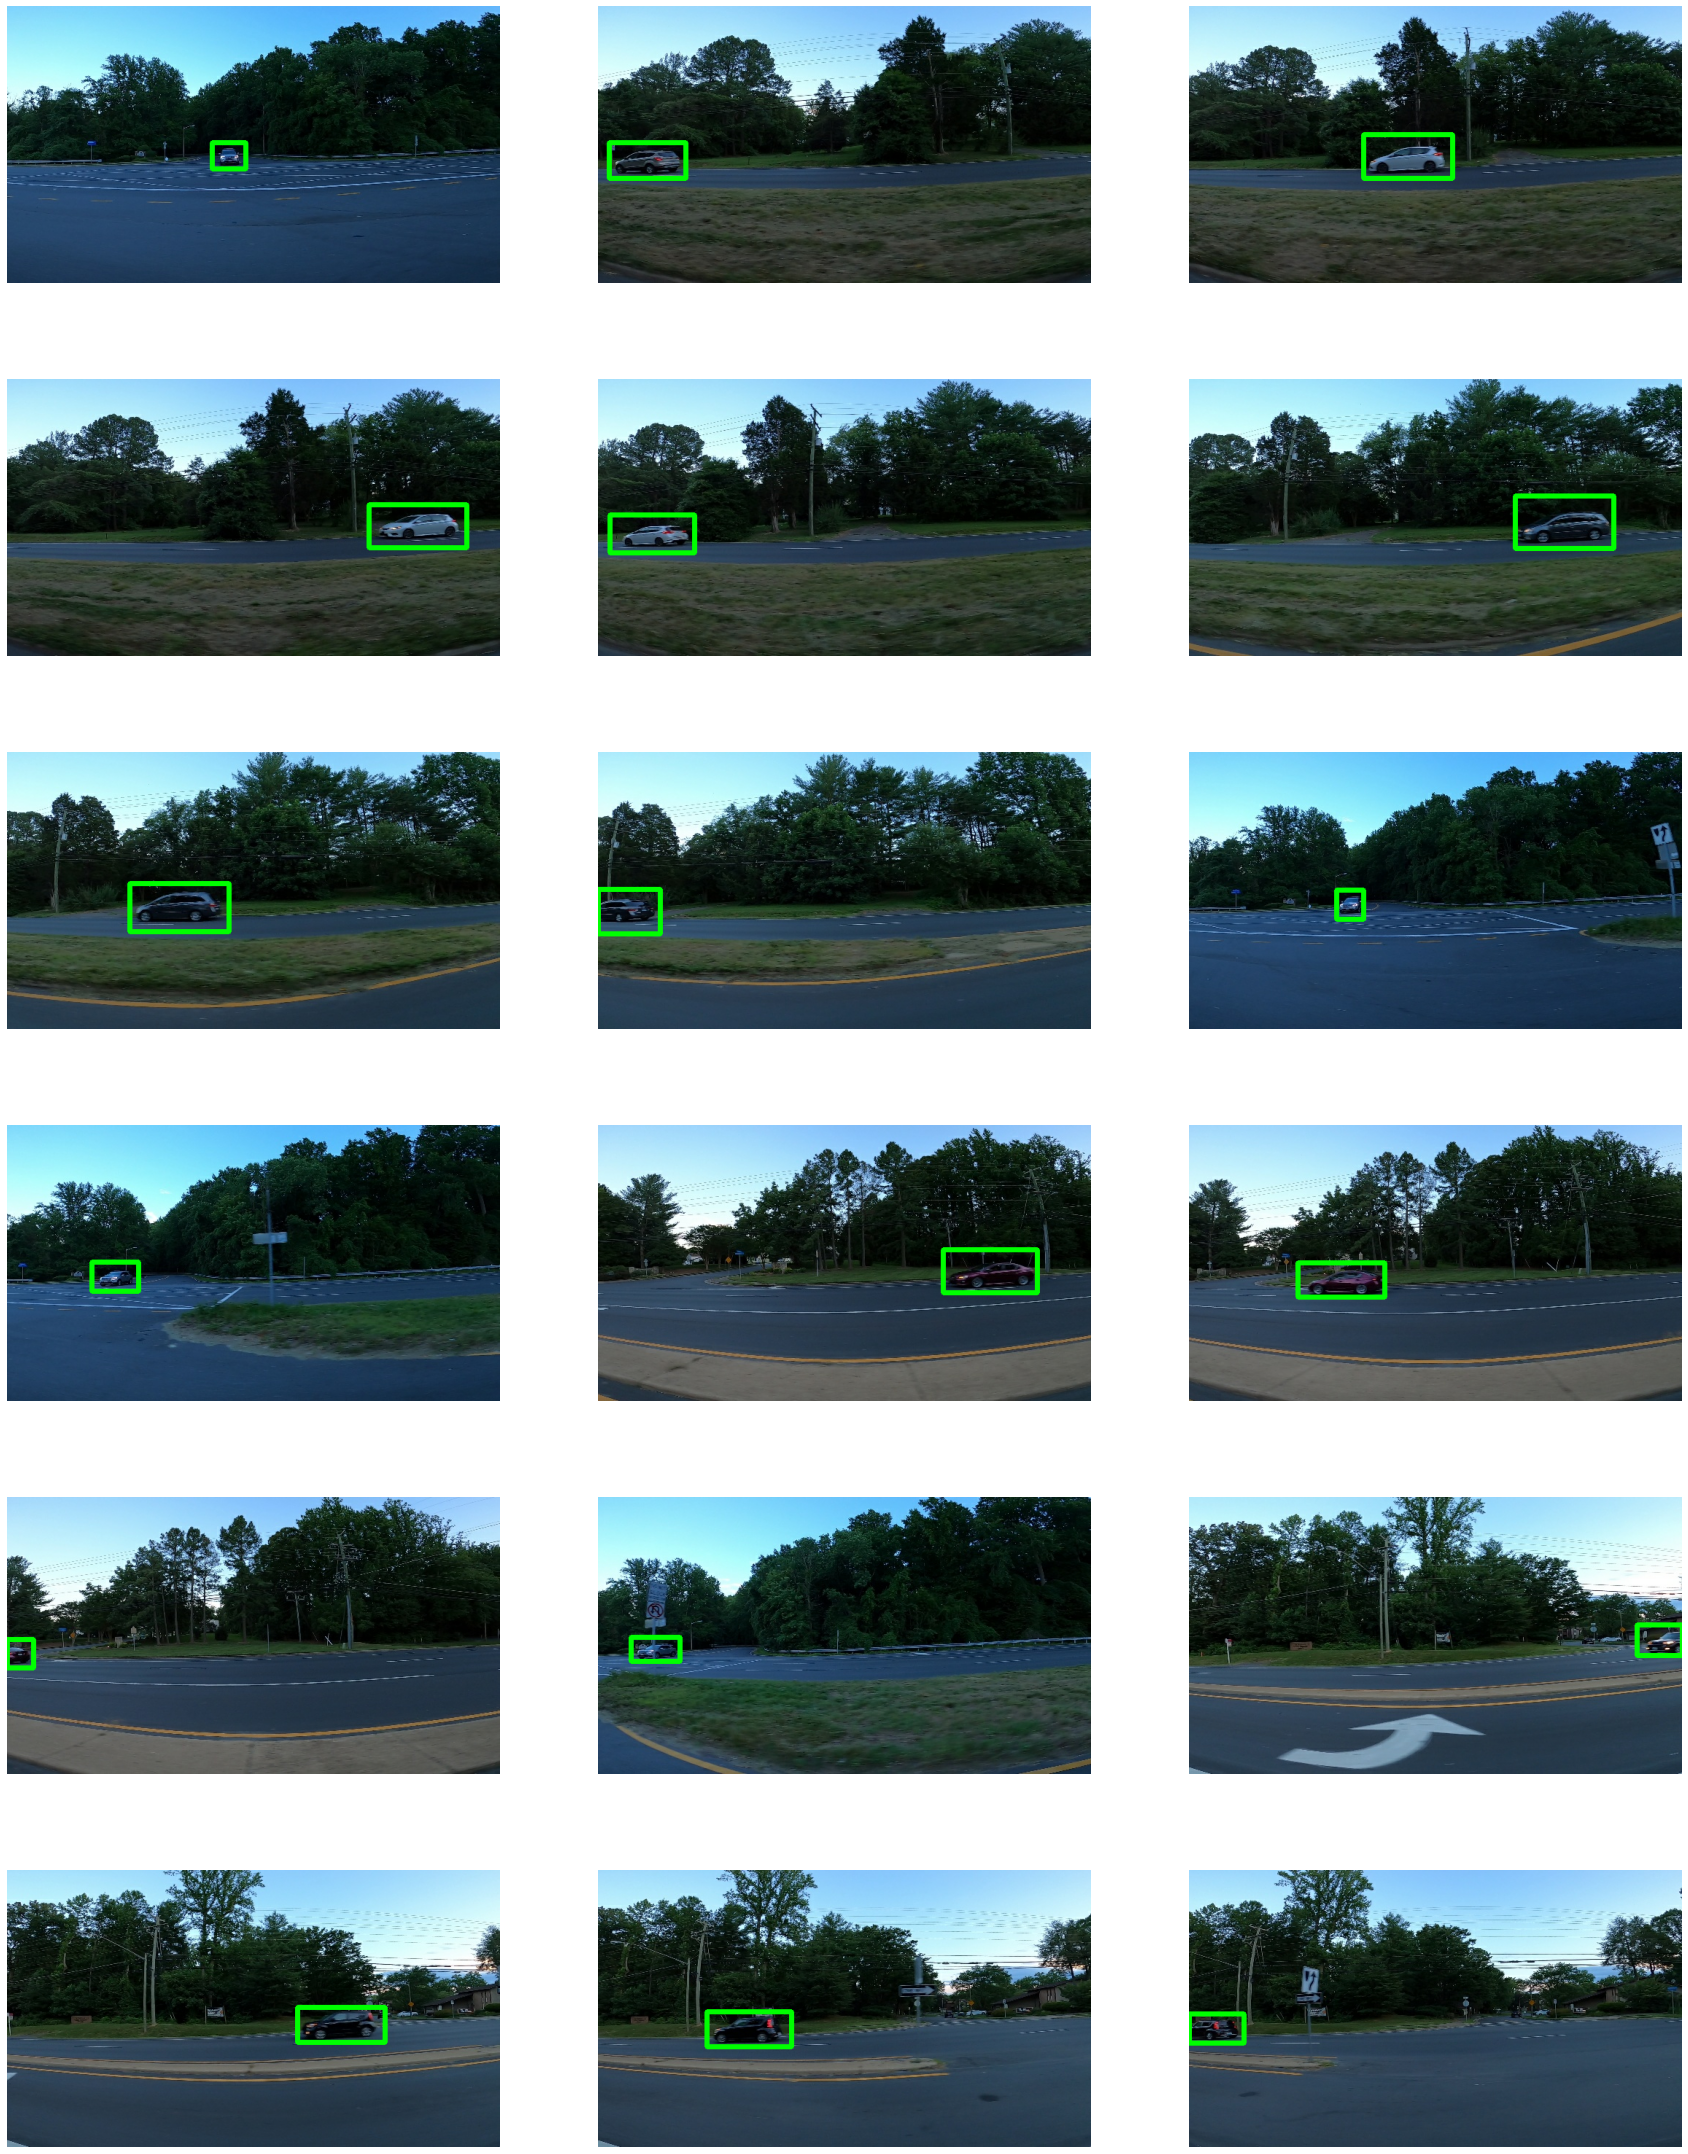

In [10]:
# Training Data
dataset = [images, bounding_boxes]
show_images_and_bbs(data = dataset)

**Great progress!** With the ability to **visualize the images and draw bounding boxes around the objects**, we have a **better understanding** of the **data we're working with**. Now, we can focus on **building the model** that will **learn to detect** and **localize objects in these images**.

# **YOLOv3 - You Only Look Once**
---
**YOLO (You Only Look Once)** is a **popular object detection algorithm** that can **recognize objects** in **images and videos in real-time**. **YOLOv3 is the latest version** of this **algorithm** and has **significantly improved the detection accuracy compared to its earlier versions**.

The **main idea** behind **YOLO** is to **divide the input image** into a **grid of cells** and for each cell, the **algorithm predicts** a set of **bounding boxes**, **confidence scores**, and **class probabilities**. The **predicted bounding boxes** are parameterized relative to the **corresponding cell**, and they **predict the center coordinates**, **width, and height of the object**. The **confidence score** indicates how **confident the algorithm** is that there is an **object in that box**, and the **class probabilities predict** the **probability of the object belonging to each class**.

**YOLOv3** introduces a **number of improvements** over its predecessor, including:

* **Feature Pyramid Network (FPN)**: YOLOv3 uses an FPN to extract features at different scales, allowing it to detect objects of different sizes.

* **Darknet-53 Backbone**: YOLOv3 uses a deep neural network architecture called Darknet-53 as its backbone. Darknet-53 is a powerful convolutional neural network that can extract features from images at different levels of abstraction.

* **Spatially-Separable Convolutional Layers**: YOLOv3 uses a new type of convolutional layer called spatially-separable convolutional layers. These layers are more computationally efficient and allow YOLOv3 to run faster on GPUs.

Overall, **YOLOv3 is a fast** and **accurate object detection algorithm** that can be used for a **wide range of applications, from surveillance to autonomous driving**.

The **most easiest and convenient way** to use **Yolo is through OpenCV**.

In [11]:
import cv2
print(cv2.__version__)

4.7.0


In [12]:
# Initialized in Network
net = cv.dnn.readNet(
    '/content/YoloV3/yolo-coco-data/yolov3.weights', 
    '/content/YoloV3/yolo-coco-data/yolov3.cfg')

In [13]:
# Names of the layer
layer_names = net.getLayerNames()
print(f"Model Layer Name : \n{layer_names}")

Model Layer Name : 
('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_3

In [14]:
# Get the output layers of the network
output_layers_names = net.getUnconnectedOutLayersNames()
output_layers_names

('yolo_82', 'yolo_94', 'yolo_106')

**OpenCV's** **deep neural network (dnn)** module expects the **input image** to be in a **specific format** called a **"blob"**. A **blob** is a **4D numpy array** **(batch_size, channels, height, width)** that contains the **input image** after **some pre-processing**. The blob can be fed directly into the **deep neural network** for **inference**. So let's create a function that will **convert the images into blobs**.

In [15]:
def image_to_blob(image: np.ndarray) -> np.ndarray:
    """
    Convert an array of images into a 4D NumPy array in blob format. 

    Args:
        images (np.ndarray): An array of images.

    Returns:
        np.ndarray: A 4D NumPy array in blob format, where the first dimension
        represents the number of images, the second and third dimensions represent
        the size of the images, and the fourth dimension represents the color 
        channels.
    """

    # Prepare a blob of image
    blob = cv.dnn.blobFromImage(
        image = image,
        size = (416, 416), 
        mean = (0, 0, 0), 
        swapRB=True, 
        crop=False
    )
        
    # Return blob
    return blob

A **blob** is a **multi-dimensional array** that contains the **image pixel values** and is processed by **deep learning models**.

The `cv.dnn.blobFromImage()` function takes the following parameters:

* **image**: The input image to be transformed into a blob.
* **scalefactor**: The scale factor used to divide the image pixel values. A value of 1/255 is commonly used.
* **size**: The size of the output image blob. YOLOv3 model takes 416x416 size as input.
* **mean**: The mean value subtracted from each channel of the image. In this case, (0,0,0) is used as there is no need to subtract any values.
* **swapRB**: A boolean flag indicating whether to swap the Red and Blue channels. YOLOv3 requires input images to be in BGR format.
* **crop**: A boolean flag indicating whether to crop the image or not. In this case, it is set to False.

The **resulting blob** is then used as **input to the YOLOv3 model for object detection**.

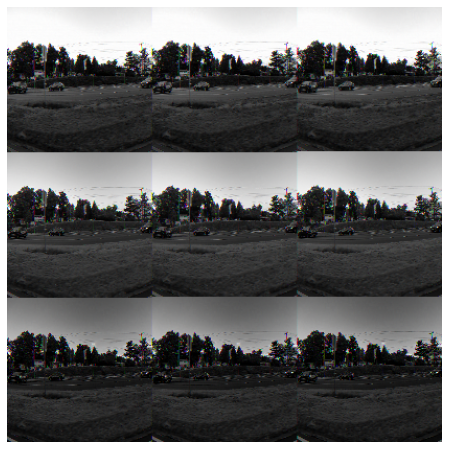

In [16]:
# Get Image
input_img = images[random.randint(0,len(images))]

# Convert all images to blobs.
blob = image_to_blob(input_img)

# Visualize the blobs
plt.figure(figsize=(8, 8))

# Process the blob.
temp_blob = tf.reshape(tf.squeeze(blob), (416,416,3))
    
# Plot the image
plt.imshow(temp_blob)
    
# Turn off the axis
plt.axis('off')

# Show the final plot.
plt.show()

In [17]:
# Set it as input to the network
net.setInput(blob)

# Apply forward propagation and get the output
layerOutputs = net.forward(output_layers_names)

Now we have to layer output. Let's first perform a **filter based on the confidence score, or the probability**.

In [18]:
def filter_output_probs(threshold_probability: float, layer_outputs: tuple) -> list:
    
    """
    Filters the detections from the output of a YOLO object detection model, by keeping only those with confidence scores
    above a specified threshold probability. Returns the bounding boxes, confidence scores, and class IDs of the filtered
    detections.

    Args:
        threshold_probability (float): The minimum confidence score for a detection to be included. Must be in the range [0, 1].
        layerOutputs (List): The output layers of a YOLO object detection model.

    Returns:
        Tuple[List[int], List[float], List[int]]: A tuple containing:
        - a list of bounding boxes, where each box is represented by a list of four integers (x_min, y_min, box_width, box_height);
        - a list of confidence scores, where each score is a float between 0 and 1;
        - a list of class IDs, where each ID is an integer corresponding to the index of the detected class label in the model's class labels list.
    """
    
    # Check validity of threshold_probability value
    if threshold_probability is None:
        raise ValueError("Invalid value for threshold_probability. Value cannot be `None`.")
    elif threshold_probability < 0 or threshold_probability > 1.0:
        raise ValueError(f"Cannot assign value {threshold_probability} to threshold_probability, value must be in range [0-1]")
    
    # Initialize variables to store object detection results
    boxes = []        # Bounding box coordinates for each detected object
    confidences = []  # Confidence score for each detected object
    class_ids = []    # Class ID for each detected object

    # Loop over the output layers from the YOLO model
    for output in layer_outputs:

        # Loop over each detection in the output
        for detection in output:

            # Extract the class probabilities and class ID for the current detection
            probabilities = detection[5:]
            class_id = np.argmax(probabilities)

            # Extract the confidence (probability) for the current detection
            confidence = probabilities[class_id]

            # Filter out weak detections with confidence below the given threshold_probability
            if confidence > threshold_probability:

                # Extract the bounding box coordinates and scale them to the size of the input image
                box = detection[0:4] * np.array([IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_HEIGHT])

                # Convert the YOLO-format bounding box (center_x, center_y, width, height) to
                # the OpenCV-format bounding box (x_min, y_min, width, height) for drawing later
                center_x, center_y, box_width, box_height = box.astype('int')
                x_min = int(center_x - (box_width / 2))
                y_min = int(center_y - (box_height / 2))

                # Add the results to the output lists
                boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    # Return the filtered results
    return boxes, confidences, class_ids

In **YOLO**, the **bounding box coordinates** are **normalized values** that range from **0 to 1** relative to the **size of the input image**. However, we need to convert these **normalized coordinates** to the **coordinates on the original image** to **draw the bounding box**. Therefore, **we multiply the normalized coordinates** by the **width and height** of the **original image** to get **the actual pixel values.**

For example, if the **normalized bounding box coordinates** are **[0.1, 0.2, 0.3, 0.4]** and the **original image size is (800, 600),** then the **actual bounding box** coordinates will be **[80, 120, 240, 240]**. We get these values by **multiplying [0.1, 0.2, 0.3, 0.4] with [800, 600, 800, 600], respectively**.

In [19]:
# Filter out all the predicted bounding boxes based on their probabilities
boxes, confidences, class_ids = filter_output_probs(PROB_THRESH, layerOutputs)

In [20]:
confidences

[0.9816470742225647,
 0.9690301418304443,
 0.9470747709274292,
 0.9881762862205505]

After applying the **YOLO model** on the **input images**, it **generates a large number of bounding boxes** for **each image** with their respective **confidence scores**. However, many of **these bounding boxes** may **overlap and represent the same object**. To filter out these **redundant boxes**, we need to **perform non-maximum suppression (NMS)**. **NMS** is a **process that removes overlapping boxes based on their Intersection over Union (IoU) score**.

After **applying probability-based filtration** on the **predicted bounding boxes**, we can use **OpenCV's dnn.NMSBoxes()** function to **perform NMS** on the **remaining boxes**. However, this **function only applies NMS to one output at a time**. Therefore, we need to create a **custom function** that can **apply NMS to multiple outputs generated by the YOLO model.**

In [21]:
# Apply non max suppression to all the predictions
indicies = cv.dnn.NMSBoxes(boxes, confidences, PROB_THRESH, IoU_THRESH, top_k=5)
indicies

array([3, 0], dtype=int32)

In [22]:
def draw_bounding_boxes(input_img: np.ndarray, boxes: list, class_ids: list, confidences: list, labels: list, indicies: list) -> None:
    """
    Draw bounding boxes around the detected objects in an image and label them with their corresponding class names and confidences.
    
    Args:
        input_img (np.ndarray): The input image in the format of numpy array.
        boxes (list): A list of boxes for each detected object in the format of [x, y, w, h], where x and y are the coordinates of the top-left corner of the box, and w and h are the width and height of the box.
        class_ids (list): A list of class IDs for each detected object.
        confidences (list): A list of confidences for each detected object.
        labels (list): A list of class names corresponding to their IDs.
    
    Returns:
        None
    """
    
    # Create a copy of the input image
    image_temp = input_img.copy()
    
    
    # Loop over each index in indicies
    for index in indicies:
        
        # Get the box coordinates and confidence for the current index
        x, y, w, h = boxes[index]
        confidence = confidences[index]
        
        # Set the color randomly
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

        
        # Draw a bounding box around the object
        cv.rectangle(image_temp, (x, y), (x+w, y+h), color=color, thickness=2)
        
        # Create a text label for the object class and confidence
        text_label = '{}:{:.2f}'.format(labels[class_ids[index]], confidence)
        
        # Set the font face and scale
        font_face = cv.FONT_HERSHEY_DUPLEX
        font_scale = 1.5
        font_thickness = 2
        
        # Draw the text label above the bounding box
        cv.putText(
            img=image_temp, 
            text=text_label, 
            org=(x+5, y-10),
            fontFace=font_face, 
            fontScale=font_scale,
            color=color, # Set the font color to random
            thickness=font_thickness
        )
    
    # Display the image
    plt.imshow(image_temp)
    plt.axis('off')

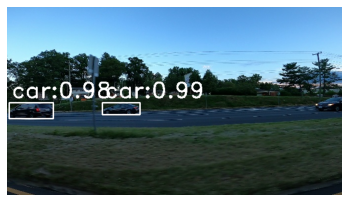

In [23]:
draw_bounding_boxes(input_img, boxes, class_ids, confidences, labels, indicies)

Let's add everything into one function.

In [24]:
def pred_bbs(image: np.ndarray, threshold_probability: float=0.9, iou_threshold: float=0.5, labels: list=labels) -> None:
    """
    Perform object detection on an input image using a pre-trained neural network, and draw bounding boxes around detected objects.
    
    Args:
    - image: A numpy array representing the input image.
    - threshold_probability: A float representing the minimum probability threshold for a detected object to be considered valid. Defaults to 0.9.
    - iou_threshold: A float representing the intersection over union threshold for Non-Maximum Suppression (NMS). Defaults to 0.5.
    - labels: A list of strings representing the class labels for the detected objects. Defaults to the global 'labels' variable.
    
    Returns:
    - None.
    """
    
    # Convert image to blob
    blob = image_to_blob(image)
    
    # Make prediction
    net.setInput(blob)
    output_layers_names = net.getUnconnectedOutLayersNames()
    outputs = net.forward(output_layers_names)
    
    # Filter the inputs based on probability
    bboxes, confidences, class_ids = filter_output_probs(threshold_probability = threshold_probability, layer_outputs = outputs)
    
    # Apply Non Max Suppression
    indicies = cv.dnn.NMSBoxes(bboxes = bboxes, scores = confidences, score_threshold = threshold_probability, nms_threshold = iou_threshold)
    
    # Draw the Bounding Box
    draw_bounding_boxes(input_img = image, boxes = bboxes, class_ids = class_ids, confidences = confidences, labels = labels, indicies = indicies)


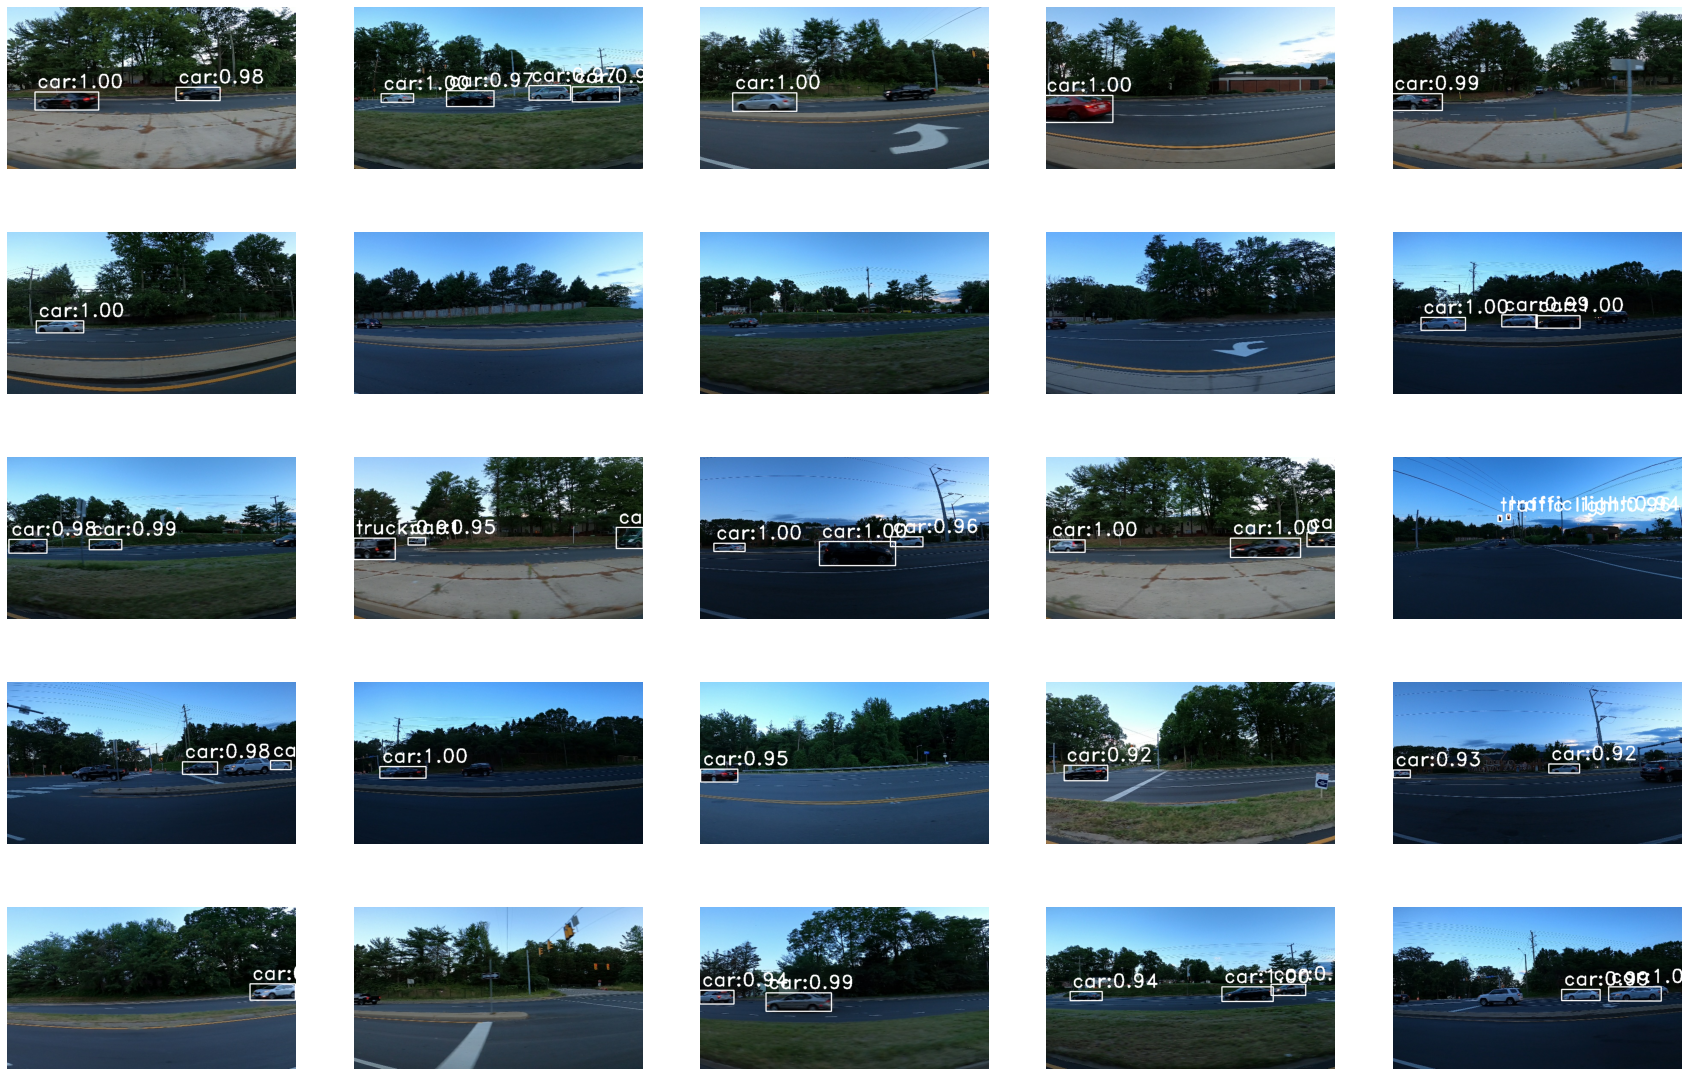

In [25]:
# Constant
N_IMAGES = 25

def plot_random_images(images: np.ndarray) -> None:
    """
    Plots a grid of N_IMAGES random images along with the detected objects bounding boxes.
    
    Args:
    - images (np.ndarray): Array of images to plot.
    
    Returns:
    - None
    """
    
    # Plotting Configuration
    plt.figure(figsize=(30,20))
    
    # For n number of images
    for n in range(N_IMAGES):
        
        # Subplot 
        plt.subplot(int(np.sqrt(N_IMAGES)), int(np.sqrt(N_IMAGES)), n+1)
        
        # Select Image Randomly
        image = images[np.random.randint(len(images))]
        
        # Detcted objects
        pred_bbs(image)
        
    # Show final plot
    plt.show()
    
# Plot images
plot_random_images(images)

**Excellent!** The model's **high confidence** in its **predictions** is a **strong indication** of its **robustness and accuracy**. With almost **all predictions being correct**. This is **particularly impressive** given the **complexity and variability of the objects being detected**. It is a testament to the **quality of the training data**, the **effectiveness of the model architecture**, and the **skillful tuning of the hyperparameters**. Overall, this is a **highly promising result for the model's potential real-world applications**.

---
**DeepNets**

In [34]:
cv2.dnn.writeNet('myyolov3.weights', net)

AttributeError: ignored